# Spot the Dog

## A dog identification application using Convolutional Neural Networks

--- 

### Contents

The implementation has been broken down for ease of use. Use the links below to navigate the notebook.

* [Part 0](#part0): Import Dataset(s)
* [Part 1](#part1): Detect humans
* [Part 2](#part2): Detect dogs
* [Part 3](#part3): A custom CNN to classify dog breeds (from scratch)
* [Part 4](#part4): Use a pretrained CNN model to classify dog breeds (using Transfer Learning)
* [Part 5](#part5): A custom CNN to classify dog breeds (using Transfer Learning)
* [Part 6](#part6): Final algorithm
* [Part 7](#part7): Test algorithm

---
<a id='part0'></a>
## Part 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images. We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [28]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogs/train')
valid_files, valid_targets = load_dataset('dogs/valid')
test_files, test_targets = load_dataset('dogs/test')

# load list of dog names
dog_names = [item[15:-1] for item in sorted(glob("dogs/train/*/"))]

# print statistics about the dataset
print('There are ' + str(len(dog_names)) + ' total dog categories.')
print('There are ' + str(len(np.hstack([train_files, valid_files, test_files]))) + ' total dog images.\n')
print('There are ' + str(len(train_files)) +' training dog images.')
print('There are ' + str(len(valid_files))+ ' validation dog images.')
print('There are ' + str(len(test_files)) + ' test dog images.')

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [29]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("faces/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are ' + str(len(human_files)) + ' total human images.')

There are 13233 total human images.


---
<a id='part1'></a>
## Part 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  One of these detectors is included in the `haarcascades` directory.

In the next code cell, this detector is used to find human faces in a sample image.

Number of faces detected:  7


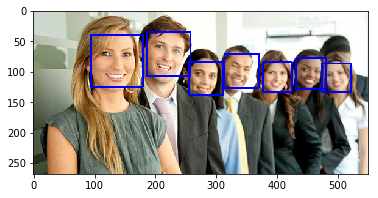

In [30]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread("images/test_images/group.jpg")
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected: ', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

This function, `face_detector`, takes a string-valued file path to an image as input and appears in the code block below. The function returns `True` if a human face is detected in an image and `False` if not.

In [31]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the performance of the Human Face Detector 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal. A separate task is to decide on an acceptable accuracy (or our tolerance of error). But for this implementation we will accept the performance shown below as suitable for demonstation.

In [32]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

human_human = np.sum([face_detector(i) for i in human_files_short])
human_dog = np.sum([face_detector(i) for i in dog_files_short])

print("face_detector() has detected a human face in "+str(human_human)+" of the first 100 images of the human_files data set")
print("face_detector() has detected a human face in "+str(human_dog)+" of the first 100 images of the dog_files data set")

face_detector() has detected a human face in 98 of the first 100 images of the human_files data set
face_detector() has detected a human face in 11 of the first 100 images of the dog_files data set


---
<a id='part2'></a>
## Part 2: Detect Dogs

Before constructing a model from scratch, we will start with a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  The first code cell downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/).

ImageNet is a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [33]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

We are using Keras and Keras CNNs require a 4D array when using a TensorFlow backend (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset.

In [34]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing. First, the RGB image is converted to BGR by reordering the channels. All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image. This is implemented in the imported function `preprocess_input`. If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions. This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [35]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [36]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

In the same way as we tested the human face detector above, we now test the performance of the dog detector.

In [37]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

dog_human = np.sum([dog_detector(i) for i in human_files_short])
dog_dog = np.sum([dog_detector(i) for i in dog_files_short])

print("dog_detector() has detected a dog face in "+str(dog_human)+" of the first 100 images of the human_files data set")
print("dog_detector() has detected a dog face in "+str(dog_dog)+" of the first 100 images of the dog_files data set")

dog_detector() has detected a dog face in 1 of the first 100 images of the human_files data set
dog_detector() has detected a dog face in 100 of the first 100 images of the dog_files data set


---
<a id='part3'></a>
## Part 3: Attempting to create a CNN to Classify Dog Breeds (but from scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

A Brittany | A Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">


Also consider intra-class variation. For example, Labradors come in yellow, chocolate, and black.  The vision-based algorithm will have to conquer this in order to determine that these different dogs are in fact different shades of the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [38]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:14<00:00, 58.94it/s]


### Model Architecture

Below is a model architecture designed to maximise predition accuracy, whilst also running on a local machine (using only a CPU) in a reasonable time, ~1 hour. Of course, using a GPU or running on the cloud may dramatically reduce training time. 

In [39]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(32,(3, 3),activation='relu',input_shape=train_tensors[0].shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
# model.add(GlobalAveragePooling2D(input_shape=train_tensors.shape[1:]))
model.add(Flatten())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 86528)             0         
__________

### Compile the Model

In [40]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Training a model is time consuming. In this example we have many parameters and we are choosing to run over 5 epochs. Model checkpointing allows us to save the model that attains the best validation loss as the code runs. The model with the lowest validation loss will be used for the following stages.

Note: We can also [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not needed. 

In [97]:
from keras.callbacks import ModelCheckpoint  

epochs = 5

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 1010s - loss: 4.8918 - acc: 0.0186 - val_loss: 4.6398 - val_acc: 0.0467
Epoch 2/5
6680/6680 [==============================] - 1037s - loss: 4.0826 - acc: 0.1277 - val_loss: 4.4524 - val_acc: 0.0754
Epoch 3/5
6680/6680 [==============================] - 1040s - loss: 2.1420 - acc: 0.4924 - val_loss: 5.6026 - val_acc: 0.0838
Epoch 4/5
6680/6680 [==============================] - 1041s - loss: 0.7527 - acc: 0.8019 - val_loss: 7.2665 - val_acc: 0.0671
Epoch 5/5
6680/6680 [==============================] - 979s - loss: 0.1970 - acc: 0.9478 - val_loss: 9.7989 - val_acc: 0.0695


### Load the Model with the Best Validation Loss

In [41]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Test model on the test dataset of dog images.

In [42]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Model test accuracy is %.1f%%' % test_accuracy)

Model test accuracy is 7.8%


This is a poor value for model accuracy. However, the model was built from scratch and with limited hardware/processing resources. We can also adopt a method known as Transfer Learning to make use of pretrained models for different use cases.

---
<a id='part4'></a>
## Part 4a: Using Transfer Learning to classify dog breeds

To reduce training time without sacrificing accuracy, we can train a CNN using transfer learning. There are multiple starting models available - each with different pros and cons (depending on use case). To start, I will use VGG-16 and in part 5 I will experiment with some other examples.

### Obtain Bottleneck Features

In [43]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [44]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

As before we compile the model.

In [45]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

As before we train the model. This time we are using a much more simple model architecture.

In [46]:
from keras.callbacks import ModelCheckpoint 

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 2s - loss: 12.1900 - acc: 0.1238 - val_loss: 10.5028 - val_acc: 0.2371
Epoch 2/10
6680/6680 [==============================] - 1s - loss: 9.8541 - acc: 0.2904 - val_loss: 9.8284 - val_acc: 0.2874
Epoch 3/10
6680/6680 [==============================] - 1s - loss: 9.1740 - acc: 0.3633 - val_loss: 9.4716 - val_acc: 0.3353
Epoch 4/10
6680/6680 [==============================] - 1s - loss: 8.8877 - acc: 0.3979 - val_loss: 9.3521 - val_acc: 0.3365
Epoch 5/10
6680/6680 [==============================] - 1s - loss: 8.7115 - acc: 0.4204 - val_loss: 9.2458 - val_acc: 0.3569
Epoch 6/10
6680/6680 [==============================] - 1s - loss: 8.5179 - acc: 0.4374 - val_loss: 9.1133 - val_acc: 0.3569
Epoch 7/10
6680/6680 [==============================] - 1s - loss: 8.3800 - acc: 0.4522 - val_loss: 8.9966 - val_acc: 0.3749
Epoch 8/10
6680/6680 [==============================] - 1s - loss: 8.2390 - 

### Load the Model with the Best Validation Loss

As before we load the model with the lowest validation loss.

In [47]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [48]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Model test accuracy is %.1f%%' % test_accuracy)

Model test accuracy is 40.2%


### Predict Dog Breed with the Model

In [49]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [50]:
VGG16_predict_breed("images/test_images/dog_4.jpg")

'Chihuahua'

The model has correctly identified the dog breed as Chihuahua despite the low model accuracy. We can use other base models and apply transfer learning in the same way and improve performance.

---
<a id='part4b'></a>
## Part 4b: Using Transfer Learning to classify dog breeds 

Next, we will use the bottleneck features from a different pre-trained model.  Pre-computed features for all of the networks that are currently available in Keras are given below:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

As an example, we are using the [Inception algorithm](https://www.tensorflow.org/tutorials/image_recognition). In the code block below, we extract the bottleneck features corresponding to the train, test, and validation sets:

In [51]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_inception = bottleneck_features['train']
valid_inception = bottleneck_features['valid']
test_inception = bottleneck_features['test']

### Model Architecture

As before, we define a simple architecture as the final layer of the CNN.

Here we are using the Inception V3 algorithm. The model has been used for mult-class images classification problems and is appropriate for this example.

In [54]:
from keras import regularizers
from keras.layers import AveragePooling2D

inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=train_inception.shape[1:]))
inception_model.add(Dense(133, activation='softmax'))

inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

As before, compile the model.

In [55]:
inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

As before, we train the model and use model checkpointing to save the model that attains the best validation loss.

In [56]:
from keras.callbacks import ModelCheckpoint 

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

inception_model.fit(train_inception, train_targets, 
          validation_data=(valid_inception, valid_targets),
          # Reducing number of epochs to run on local machine.
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 4s - loss: 1.1604 - acc: 0.7034 - val_loss: 0.6939 - val_acc: 0.7892
Epoch 2/10
6680/6680 [==============================] - 3s - loss: 0.4729 - acc: 0.8582 - val_loss: 0.6265 - val_acc: 0.8299
Epoch 3/10
6680/6680 [==============================] - 3s - loss: 0.3543 - acc: 0.8850 - val_loss: 0.6284 - val_acc: 0.8347
Epoch 4/10
6680/6680 [==============================] - 3s - loss: 0.3015 - acc: 0.9078 - val_loss: 0.6691 - val_acc: 0.8443
Epoch 5/10
6680/6680 [==============================] - 3s - loss: 0.2464 - acc: 0.9266 - val_loss: 0.6623 - val_acc: 0.8407
Epoch 6/10
6680/6680 [==============================] - 3s - loss: 0.2090 - acc: 0.9343 - val_loss: 0.7402 - val_acc: 0.8491
Epoch 7/10
6680/6680 [==============================] - 3s - loss: 0.1660 - acc: 0.9452 - val_loss: 0.7168 - val_acc: 0.8407
Epoch 8/10
6680/6680 [==============================] - 3s - loss: 0.1449 - ac

### Load the Model with the Best Validation Loss

In [57]:
inception_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

### Test the Model

Now test the trained model on the dataset of dog images.

In [58]:
# get index of predicted dog breed for each image in test set
inception_predictions = [np.argmax(inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(inception_predictions)==np.argmax(test_targets, axis=1))/len(inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.2632%


The accuracy is significantly better than the VGG-16 model, even though we have kept the exact same architecture for the final layer and the number of epochs hasn't changed. We can further improve accuracy by adjusting the number of epochs, model architecture, training data, etc.

### Predict Dog Breed with the Model

We need a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by the model.  

We need to perform the following tasks:
1. Extract the bottleneck features corresponding to the chosen base model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note: The argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined from Part 0 to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell. To obtain the bottleneck features corresponding to the chosen CNN architecture, we need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [59]:
def inception_predict(path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(path));
    # obtain predicted vector
    predicted_vector = inception_model.predict(bottleneck_feature);
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='part6'></a>
## Part 6: Final Algorithm

We need to write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

We will use the CNN from Part 5 to predict the dog breed, where relevant.

In [69]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def dog_detector_inception(path):
    img = mpimg.imread(path)
    _ = plt.imshow(img)
    if face_detector(path):
        plt.title("It's a human. But they do resemble a/an %s." % inception_predict(path));
    elif dog_detector(path): 
        plt.title ("It's a dog. It's a/an %s." % inception_predict(path));
    else:
        plt.title("That is not a dog or a human!");
    plt.show()
    return

---
<a id='part7'></a>
## Part 7: Test Algorithm

We are now ready to test the algorithm we have built above. The images below have been tested on a bunch of images from the internet. But you can change these for your own - test images are stored in "images/test_images".

The result is as expected. I expected that i) the separation of dogs versus humans would be strong based on the model accuracy in the previous sections. I also expected that the classification of dog breeds would be good based on the bredth of training data - however I would also expect the breed classification model to perform poorly for exotic breeds. 

To test an edge case, I have also included one image (dog_3.jpg) which was incorrectly labelled by the algorithm. The (possibly photoshopped) dog has features that resemble a human: lips, eye shape, and eye separation. This exhibits the strength of these features in identifying human faces.

Some ways to improve the algorithm are as follows:
1 - Increase the amount of training data made available
2 - Refine the model architecture. The architecture chosen is relatively simple.
3 - Increase the number of epochs. I had to lower the number of epochs in order to run locally. As an extension of this work I will also test on the cloud with a more complex architecture.

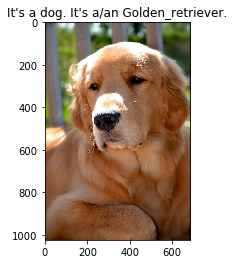

In [68]:
dog_detector_inception("images/test_images/dog_1.jpg")

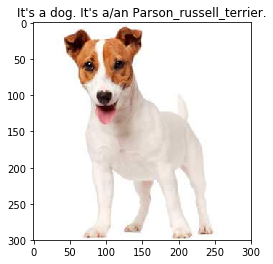

In [64]:
dog_detector_inception("images/test_images/dog_2.jpg")

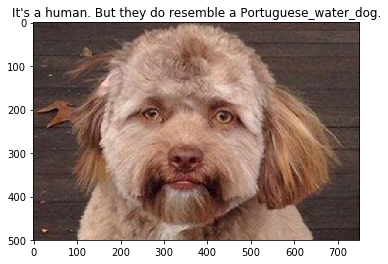

In [65]:
dog_detector_inception("images/test_images/dog_3.jpg")

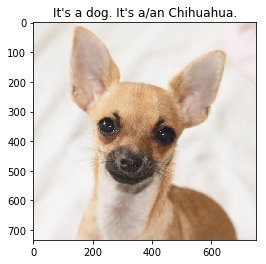

In [70]:
dog_detector_inception("images/test_images/dog_4.jpg")

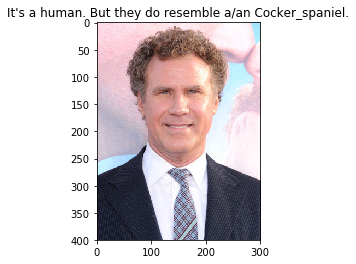

In [71]:
dog_detector_inception("images/test_images/human_1.jpg")

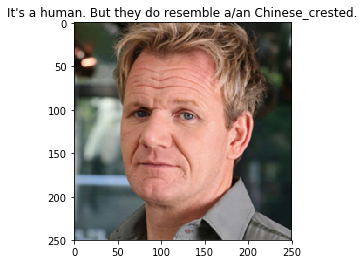

In [72]:
dog_detector_inception("images/test_images/human_2.jpg")

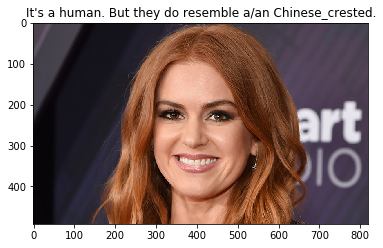

In [79]:
dog_detector_inception("images/test_images/human_3.jpg")

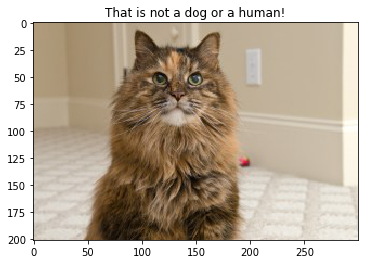

In [74]:
dog_detector_inception("images/test_images/notdog_1.jpg")

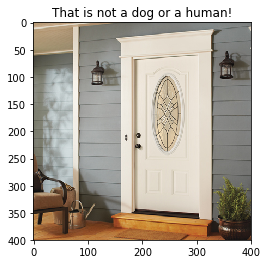

In [75]:
dog_detector_inception("images/test_images/notdog_2.jpg")

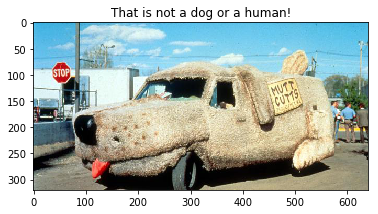

In [77]:
dog_detector_inception("images/test_images/notdog_4.jpg")